# Final Report: Room for the River

This file contains the code used for the analysis in the final assignment for Model-based Decision-making.


**Course: EPA1361 2020-2021**

**Group 13: Sebas Beaujon, Alex Chiodo, Niklas Engberg, Marron Loods, Jasmine Pattany, Puck Wammes**

## Analysis

A MORDM optimization has been executed to produce a policy advice for the province **Gelderland**. The EMA Workbench has been used to analyze the existing Dike Model under deep uncertainty.

## Contents

This file contains the following sections:
- Setting up the Workbench
- Open exploration:
 - Sensitivity analysis
 - Scenario discovery
- Perform MORDM
- Measuring robustness
- Solution selection

## Setting up the Workbench

- Importing necessary packages and libraries
- Problem formulation selection: Problem formulation ID = 1 or 3
- Reference scenario formulated



In [61]:
from __future__ import (unicode_literals, print_function, absolute_import,
                        division)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import functools

from ema_workbench import (Model, MultiprocessingEvaluator, Policy,
                           Scenario, ScalarOutcome, save_results, 
                           load_results)
from ema_workbench.analysis import feature_scoring, parcoords, prim
from ema_workbench.em_framework import get_SALib_problem
from ema_workbench.em_framework.evaluators import perform_experiments, SOBOL, LHS
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.optimization import EpsilonProgress

In [52]:
if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
    
# #     Get problem formulation ID 1: Expected annual damage, dike 
# #     investment costs, expected number of deaths
#     model, planning_steps = get_model_for_problem_formulation(1)
    
    # Get problem formulation ID 3: Outcomes disaggregated over locations
    model, planning_steps = get_model_for_problem_formulation(3)

    # Build a reference scenario:
    reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'ID flood wave shape': 4, 'planning steps': 2}
    reference_values.update({'discount rate {}'.format(n): 3.5 for n in planning_steps})
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split('_')

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario('reference', **scen1)
    
    # no dike increase, no warning, none of the rfr
    zero_policy = {'DaysToThreat': 0}
    zero_policy.update({'DikeIncrease {}'.format(n): 0 for n in planning_steps})
    zero_policy.update({'RfR {}'.format(n): 0 for n in planning_steps})
    pol0 = {}

    for key in model.levers:
        s1, s2 = key.name.split('_')
        pol0.update({key.name: zero_policy[s2]})

    policy0 = Policy('Policy 0', **pol0)
    
# Set option for DataFrame to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Get problem definition for Sobol analysis
problem = get_SALib_problem(model.uncertainties)

### Explore results of zero policy with PRIM scenario discovery and random forests feature scoring

For the following performed experiments, problem ID 1 has been selected to aggregate the outcomes

In [ ]:
# with MultiprocessingEvaluator(model) as evaluator:
#     experiments_pol0, outcomes_pol0 = evaluator.perform_experiments(scenarios=10000, policies=policy0,
#                                                                     uncertainty_sampling=LHS)
    
# save_results((experiments_pol0, outcomes_pol0), './results_pol0.tar.gz')

In [53]:
experiments_pol0, outcomes_pol0 = load_results('results_pol0.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Gebruiker\Documents\GitHub\EPA1361_assignments\v8 final assignment\results_pol0.tar.gz


In [54]:
# Clean experiments
dropset = ['model', 'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 
           'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 
           'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 
           'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 
           'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 
           'A.5_DikeIncrease 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', 
           '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', 
           '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2']

experiments_cleaned = experiments_pol0.drop(dropset, axis=1)

# Select deaths as outcome for scenario discovery
data = outcomes_pol0['Expected Number of Deaths']
data

array([0.97267961, 0.47995929, 0.41024744, ..., 3.21985316, 2.17990289,
       0.40912404])

In [55]:
# Using all datapoints that are within the 20% lowest number of deaths
y = data < np.percentile(data, 20)

prim_alg = prim.Prim(experiments_cleaned, y, threshold=1, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 2000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.0981, coverage: 0.4905, density: 1.0 restricted_dimensions: 4


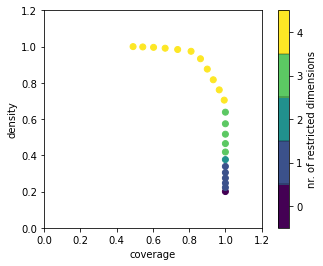

In [56]:
# Plot tradeoff PRIM between density, coverage, nr of restricted dimensions
box1.show_tradeoff()
plt.show()

The results show that with a density of 80%, the coverage is almost 100% with 4 restricted dimensions. This is an acceptable tradeoff.

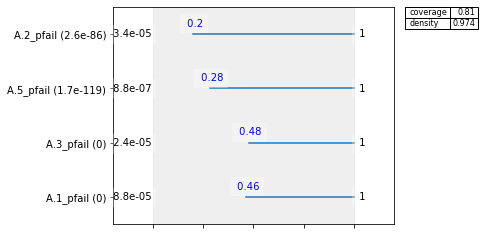

In [57]:
# Selecting box 17 to show results, has a density of 0.974 (fulfills 
# requirement density > 0.8) and high coverage. Most restricting factors are dike ring 3 and 1

box1.inspect(17,style='graph')
plt.show()

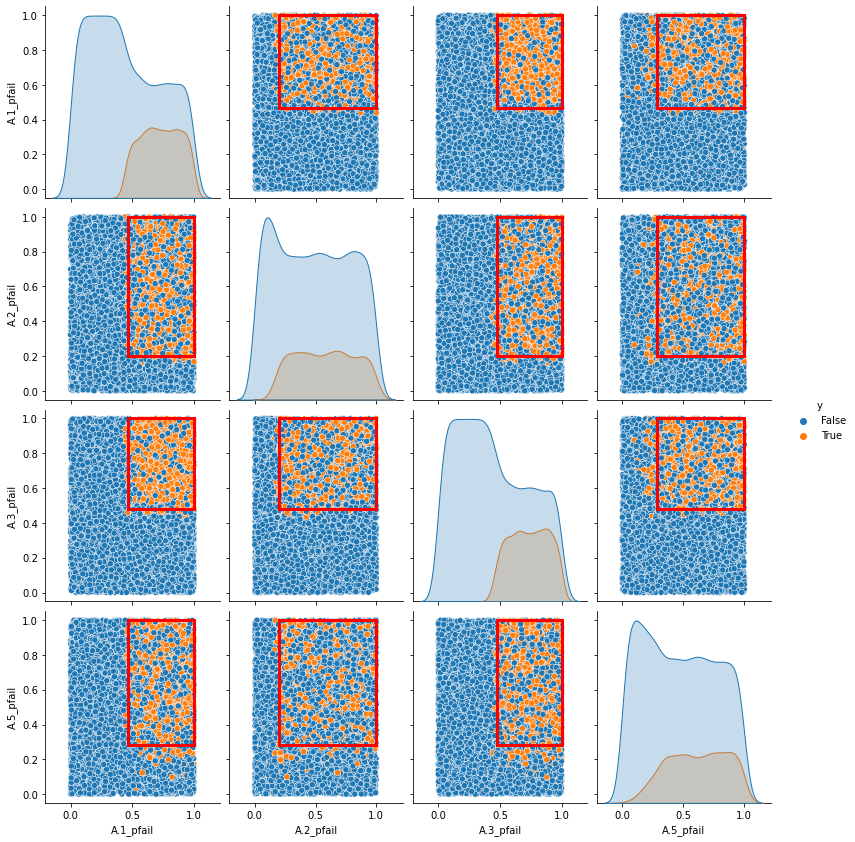

In [58]:
# Plot scatter plot of PRIM results for number of casualties

box1.select(17)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

This shows as well in the pairs scatter. The smallest box can be found in the A.1 and A.3 section. This allows the conclusion that A.1 and A.3 are crucial in order to secure a low death rate.

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category


<Figure size 576x576 with 0 Axes>

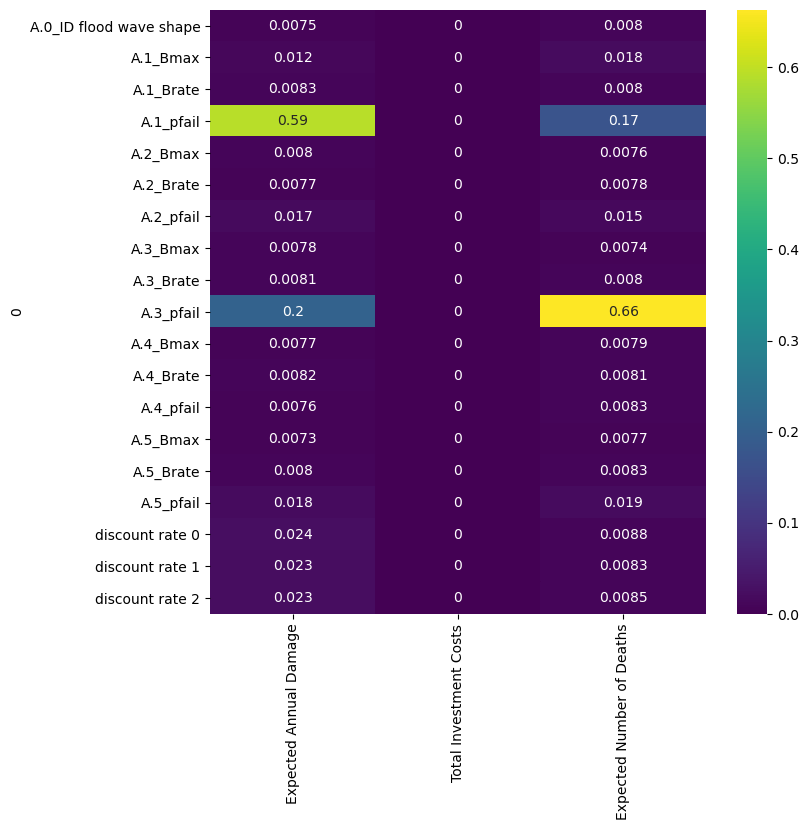

In [62]:
fig = plt.figure(figsize=(8, 8))

for policy in experiments_cleaned.policy.unique():
    plt.figure(figsize=(8, 8), dpi=100)
    logical = experiments_cleaned.policy == policy
    subset_results = {k:v[logical] for k,v in outcomes_pol0.items()}
    scores = feature_scoring.get_feature_scores_all(experiments_cleaned[logical],
                                                   subset_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.savefig('NoPolicy_heatmap.png', bbox_inches='tight')
    plt.show()

The feature scoring shows a high sensitivity of deaths and annual damage to the failure of Dikering 1 and 3 as well. Possibly, in these areas the dikes are less strong and more people live close to the Ijssel river. Consequently, these are important variables to consider.

C:\Users\Gebruiker\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


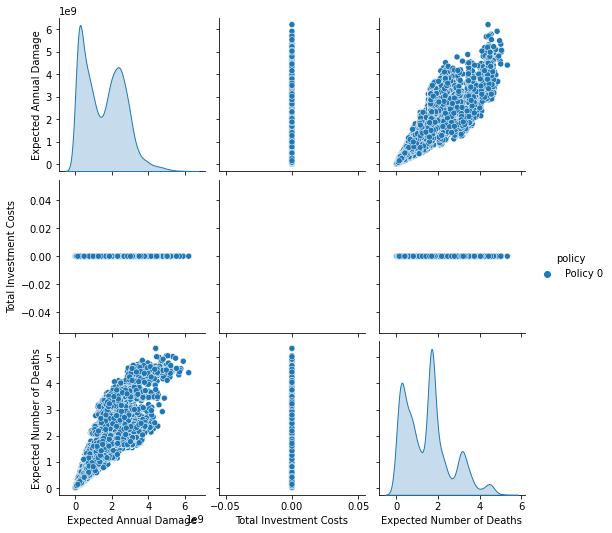

In [59]:
policies = experiments_pol0['policy']

data = pd.DataFrame.from_dict(outcomes_pol0)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes_pol0.keys(), )
plt.show()

Expected annual damage and expected number of deaths show a relatively high correlation.

In [64]:
data.max()

Expected Annual Damage       6.210308e+09
Total Investment Costs       0.000000e+00
Expected Number of Deaths    5.339035e+00
dtype: float64

In [65]:
data.min()

Expected Annual Damage       7.050893e+06
Total Investment Costs       0.000000e+00
Expected Number of Deaths    6.050163e-03
dtype: float64

Observation: In the best case scenario still 7 million€ of damage and 0.006 casualties would be caused.

### Perform experiments with reference scenario

In [ ]:
# with MultiprocessingEvaluator(model) as evaluator:
#     experiments_ref_scen, outcomes_ref_scen = evaluator.perform_experiments(scenarios=ref_scenario, policies=10000,
#                                                                     uncertainty_sampling=LHS)

# save_results((experiments_ref_scen, outcomes_ref_scen), './results_ref_scen.tar.gz')

In [66]:
experiments_ref_scen, outcomes_ref_scen = load_results('./results_ref_scen.tar.gz')
ref_scen_results = experiments_ref_scen, outcomes_ref_scen


[MainProcess/INFO] results loaded succesfully from C:\Users\Gebruiker\Documents\GitHub\EPA1361_assignments\v8 final assignment\results_ref_scen.tar.gz


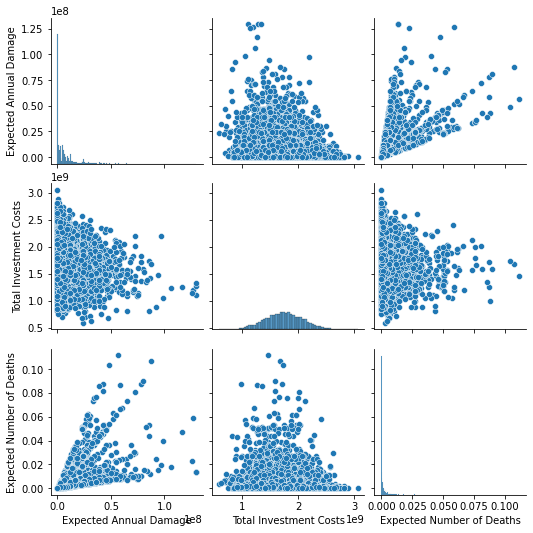

In [67]:
policies = experiments_ref_scen['policy']

data = pd.DataFrame.from_dict(outcomes_ref_scen)
data['policy'] = policies

sns.pairplot(data,  vars=outcomes_ref_scen.keys())
plt.show()

In [68]:
data.max()

Expected Annual Damage       1.292632e+08
Total Investment Costs       3.056722e+09
Expected Number of Deaths    1.115125e-01
dtype: float64

In [69]:
data.min()

Expected Annual Damage       0.000000e+00
Total Investment Costs       5.971027e+08
Expected Number of Deaths    0.000000e+00
dtype: float64

It is even possible to reduce the annual damage and expected number of deaths to zero, if the investment costs rise.

### Perform experiments under 1000 scenarios and for 2 policies, using LHS as uncertainty sampling method. 

In [4]:
# # Perform experiments
# with MultiprocessingEvaluator(model) as evaluator:
#     experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=2, uncertainty_sampling=LHS)

In [5]:
# save_results((experiments, outcomes), './results_LHS.tar.gz')

In [4]:
experiments_LHS, outcomes_LHS = load_results('results_LHS.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Gebruiker\Documents\GitHub\EPA1361_assignments\v8 final assignment\results_LHS.tar.gz


In [17]:
pd.DataFrame(outcomes_LHS).sort_values(['A.5_Expected Number of Deaths'], ascending=False)

A.1 Total Costs  A.1_Expected Number of Deaths  A.2 Total Costs  \
354      2.381382e+08                       0.000000     2.443347e+08   
1354     1.542875e+08                       0.000000     8.741814e+07   
1003     1.542875e+08                       0.000000     9.399789e+07   
3        2.878827e+08                       0.011099     2.443347e+08   
851      2.381382e+08                       0.000000     2.443347e+08   
165      2.381382e+08                       0.000000     2.443347e+08   
750      2.381382e+08                       0.000000     2.443347e+08   
757      2.381382e+08                       0.000000     2.443347e+08   
646      2.381382e+08                       0.000000     2.443347e+08   
959      2.381382e+08                       0.000000     2.443347e+08   
1165     1.542875e+08                       0.000000     9.010524e+07   
1757     1.542875e+08                       0.000000     8.180343e+07   
1851     1.542875e+08                       0.000000     1.304447e+08   
1731     1.542875e+08                       0.000000     8.359146e+07   
1750     1.542875e+08                       0.000000     8.998571e+07   
529      2.381382e+08                       0.000000     2.443347e+08   
444      2.381382e+08                       0.000000     2.443347e+08   
731      2.381382e+08                       0.000000     2.443347e+08   
1646     1.542875e+08                       0.000000     1.428710e+08   
1230     1.542875e+08                       0.000000     8.357827e+07   
1785     1.542875e+08                       0.000000     8.755159e+07   
1399     1.542875e+08                       0.000000     8.585017e+07   
1588     1.542875e+08                       0.000000     8.238237e+07   
1882     1.542875e+08                       0.000000     9.631611e+07   
1807     1.542875e+08                       0.000000     8.408827e+07   
785      2.381382e+08                       0.000000     2.443347e+08   
1607     1.542875e+08                       0.000000     9.941652e+07   
230      2.381382e+08                       0.000000     2.443347e+08   
1595     1.542875e+08                       0.000000     8.170926e+07   
1561     1.542875e+08                       0.000000     9.622610e+07   
1611     1.542875e+08                       0.000000     1.041060e+08   
1410     1.542875e+08                       0.000000     8.410755e+07   
1121     1.542875e+08                       0.000000     8.585034e+07   
1143     1.542875e+08                       0.000000     8.408917e+07   
1217     1.542875e+08                       0.000000     8.358293e+07   
1710     1.542875e+08                       0.000000     8.753385e+07   
882      2.381382e+08                       0.000000     2.443347e+08   
1178     1.542875e+08                       0.000000     8.356909e+07   
1122     1.542875e+08                       0.000000     8.581098e+07   
1670     1.542875e+08                       0.000000     8.635323e+07   
1147     1.542875e+08                       0.000000     8.480525e+07   
1443     1.542875e+08                       0.000000     9.388675e+07   
491      2.381382e+08                       0.000000     2.443347e+08   
1462     1.542875e+08                       0.000000     1.215104e+08   
1664     1.542875e+08                       0.000000     8.893266e+07   
611      2.381382e+08                       0.000000     2.443347e+08   
426      2.381382e+08                       0.000000     2.443347e+08   
1897     1.542875e+08                       0.000000     8.127741e+07   
1436     1.542875e+08                       0.000000     8.350791e+07   
1106     1.542875e+08                       0.000000     9.400941e+07   
1567     1.542875e+08                       0.000000     9.954271e+07   
1795     1.542875e+08                       0.000000     8.586635e+07   
1498     1.542875e+08                       0.000000     8.753099e+07   
1959     1.542875e+08                       0.000000     1.21325

## Insert pairplots and sensitivity analysis

## Optimization (MORDM)

Running MORDM optimization that searchers over levers to find optimized policies, for 5000 nfe, with epsilon values specified below. Only epsilon progress is used to measure convergence, hypervolume is not used because of time constraints.

The epsilon values and nfe have been selected after experimenting with different values. This combination resulted in around 140 solutions. Ideally, around 100 solutions had been found, but this number was considered close enough.

In [7]:
# ema_logging.log_to_stderr(ema_logging.INFO) 
# from ema_workbench.em_framework.optimization import (HyperVolume,
#                                                      EpsilonProgress)

# convergence_metrics = [EpsilonProgress()]

# # Epsilon values - could be lower but for time sake we kept it 0.01 (1/100)
# espilon = [20000000,0.01,20000000,0.01,20000000,0.01,200000000,0.01,200000000,0.01, ]

# nfe = 5000 
    
with MultiprocessingEvaluator(model) as evaluator:
    results_opt_final, convergence_opt_final = evaluator.optimize(nfe=nfe,
                                                                  searchover='levers',
                                                                  epsilons=espilon,
                                                                  convergence=convergence_metrics,
                                                                  reference=ref_scenario)

# save_results((results_opt, convergence_opt), './results_june14.tar.gz')

In [18]:
experiments_opt, convergence_opt = load_results('results_opt_final.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Gebruiker\Documents\GitHub\EPA1361_assignments\v8 final assignment\results_opt_final.tar.gz


In [19]:
# Print experiments to analyze results from optimization

experiments_opt

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0          1        1        1        0        1        1        1        0   
1          1        1        1        1        0        1        0        1   
2          1        1        1        0        0        0        0        1   
3          0        0        1        0        1        0        0        1   
4          0        0        1        0        1        1        1        1   
5          1        1        0        1        0        1        1        1   
6          1        0        1        0        1        0        1        1   
7          0        0        1        0        1        0        1        0   
8          1        0        1        0        0        0        1        1   
9          0        0        0        0        0        1        0        0   
10         0        0        1        0        1        1        1        1   
11         1        0        0        0        1        1        1        1   
12         1        0        1        0        1        0        1        0   
13         0        0        0        0        0        0        0        0   
14         1        1        0        0        0        1        1        1   
15         0        0        1        0        0        0        0        0   
16         0        0        0        0        0        0        0        0   
17         0        0        1        0        0        0        0        0   
18         0        0        1        0        0        0        0        1   
19         1        0        0        0        0        0        0        0   
20         0        0        0        0        0        0        0        0   
21         0        0        0        0        0        0        0        0   
22         1        0        0        0        0        0        0        0   
23         0        1        0        0        0        0        1        0   
24         1        0        0        1        0        1        1        0   
25         0        0        0        1        1        1        0        1   
26         1        0        0        1        1        1        0        0   
27         0        0        0        0        0        0        1        1   
28         1        0        0        0        0        0        1        0   
29         0        0        0        0        0        0        0        0   
30         0        0        0        0        0        0        1        0   
31         0        0        1        0        1        1        1        0   
32         0        0        1        0        1        1        0        0   
33         0        0        0        0        0        0        0        0   
34         0        0        1        0        0        1        0        0   
35         0        0        1        0        1        0        0        0   
36         0        0        1        1        1        0        1        1   
37         1        1        1        1        0        0        1        0   
38         1        0        1        1        0        0        1        1   
39         0        0        0        1        1        1        1        1   
40         0        0        1        0        1        1        0        0   
41         1        0        0        0        0        0        1        0   
42         0        0        0        0        0        0        1        0   
43         0        0        0        0        0        0        0        0   
44         0        0        0        0        0        0        0        1   
45         0        0        1        0        1        1        0        0   
46         0        0        1        0        0        0        1        1   
47         0        0        0        0        0        0        0        0   
48         1        0        1        1        0        0        0        0   
49         0        0        0        0        0       

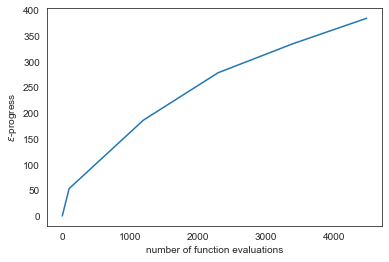

In [88]:
# Plot convergence (epsilon progress)
plt.plot(convergence_opt['nfe'], convergence_opt['epsilon_progress'])
plt.ylabel('$\epsilon$-progress')
plt.xlabel('number of function evaluations')
plt.show()

The graph shows that the algorithm does not converge yet. A further study would increase the nfe to ensure convergence, but due to time constraints these results are used for further analysis.

In the section below, the experiments and outcomes are aggregated to show the respective interests of the provinces Gelderland and Overijssel, which are used to plot trade-offs.

In the part below, someof the levers and outcomes have been aggregated to plot meaningful trade-offs for different actors. The provinces both find the costs and number of deaths for their own area the most important. Moreover, it is assumed that the provinces prefer to have little RfR projects, because these disturb their citizens which own those pieces of land. This has been accounted for by counting the number of RfR projects in the first time step (0). If a RfR project can be postponed, there is more time for the province to prepare the farmers and negotiate about a suitable transition policy.

# Remove lists that are commented out if not needed

In [20]:
# Create copy of experiments_opt to maintain original 
solutions_df = experiments_opt

In [21]:
# Calculate total costs and number of expected deaths for the three Gelderland dikes
listA = solutions_df[['A.1 Total Costs', 'A.2 Total Costs', 'A.3 Total Costs']]
solutions_df['Total Costs dikes 1-3 (Gelderland)'] = listA.sum(1)

listB = solutions_df[['A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths']]
solutions_df['Deaths dikes 1-3 (Gelderland)'] = listB.sum(1)

# Calculate the same for the two Overijssel dikes
listC = solutions_df[['A.4 Total Costs', 'A.5 Total Costs']]
solutions_df['Total Costs dikes 4-5 (Overijssel)'] = listC.sum(1)

listD = solutions_df[['A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths']]
solutions_df['Deaths dikes 4-5 (Overijssel)'] = listD.sum(1)


# Sum all costs, total costs (damages and dike investments) for all five locations, 
# total number of expected deaths to address RWS
listE = solutions_df[['A.1 Total Costs', 'A.2 Total Costs', 'A.3 Total Costs','A.4 Total Costs', 
                      'A.5 Total Costs', 'RfR Total Costs', 'Expected Evacuation Costs']]
solutions_df['Total Costs all dikes (RWS)'] = listE.sum(1)

listF = solutions_df[['A.1 Total Costs', 'A.2 Total Costs', 'A.3 Total Costs', 'A.4 Total Costs', 
                            'A.5 Total Costs']]
solutions_df['Total Costs ALL'] = listF.sum(1)

listG = solutions_df[['A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 
                            'A.3_Expected Number of Deaths',
                            'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths']]
solutions_df['Total Deaths ALL'] = listG.sum(1)   

# Create copy of solutions_df to maintain original 
selections = solutions_df


In [24]:
# Print solutions with all additional columns to analyze and determine robustness metrics
solutions_df.sort_values(['Total Deaths ALL'], ascending=False)

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
121        0        0        0        0        0        0        0        0   
34         0        0        1        0        0        1        0        0   
98         0        1        1        0        0        0        0        0   
122        0        0        0        0        0        0        0        0   
56         1        0        1        0        0        0        0        0   
135        1        0        0        0        0        0        0        1   
106        0        1        0        0        0        0        0        0   
112        0        0        0        0        0        0        0        0   
109        1        0        1        0        0        0        0        0   
141        0        0        1        1        0        0        0        0   
93         0        0        0        0        0        0        0        1   
75         0        0        0        0        0        0        0        0   
57         1        1        0        0        0        0        0        1   
53         0        0        0        0        0        0        0        0   
137        0        0        1        1        1        0        0        0   
66         0        0        0        0        0        0        0        0   
107        1        0        1        0        0        0        0        0   
80         0        0        0        0        0        0        1        1   
126        0        0        0        0        0        0        1        0   
78         1        0        1        0        0        1        0        0   
97         1        0        1        0        0        0        0        0   
68         1        0        1        0        0        1        0        0   
71         0        0        0        0        0        0        0        0   
67         0        0        1        0        0        0        0        0   
89         0        0        0        0        0        0        0        0   
69         1        0        0        0        1        0        0        0   
88         1        0        0        0        0        0        0        1   
95         1        0        1        0        1        0        0        1   
60         0        0        1        0        0        1        0        1   
132        0        0        0        0        0        0        1        0   
50         0        0        1        1        1        0        0        0   
110        0        0        1        0        0        0        1        0   
111        0        0        0        0        0        0        0        0   
113        0        0        0        0        0        0        0        0   
55         1        0        0        0        1        1        1        0   
138        0        0        1        0        0        1        0        0   
127        1        0        1        0        0        0        1        1   
79         1        0        0        0        1        0        0        0   
32         0        0        1        0        1        1        0        0   
59         1        1        0        0        0        0        1        1   
36         0        0        1        1        1        0        1        1   
131        0        0        1        0        0        0        1        1   
33         0        0        0        0        0        0        0        0   
86         0        0        0        0        0        0        0        1   
87         1        0        0        0        0        0        1        1   
65         1        1        0        0        0        0        1        1   
31         0        0        1        0        1        1        1        0   
58         0        0        0        0        0        0        0        0   
21         0        0        0        0        0        0        0        0   
43         0        0        0        0        0       

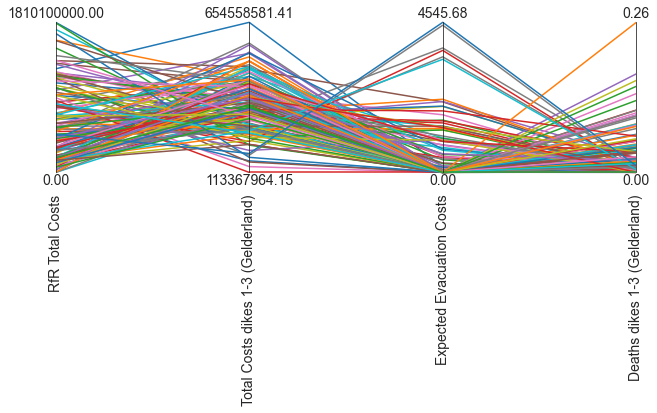

In [300]:
# Plot parallel axes of outcomes of interest to illustrate trade-offs for Gelderland

# Select axes to plot
dataG = selections.loc[:, ['RfR Total Costs','Total Costs dikes 1-3 (Gelderland)', 'Expected Evacuation Costs',
                           'Deaths dikes 1-3 (Gelderland)']]  

# Set limits of the axes to range from 0 to the maximum values for the number of deaths
limits = parcoords.get_limits(dataG)
limits.loc[0, ['Deaths dikes 1-3 (Gelderland)']] = 0  # 'RfR 4-5 (Overijssel)','RfR 1-3 (Gelderland)'

# Plot parallel coordinates
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(dataG)

fig = plt.gcf()
fig.set_size_inches(10,15)

plt.show()

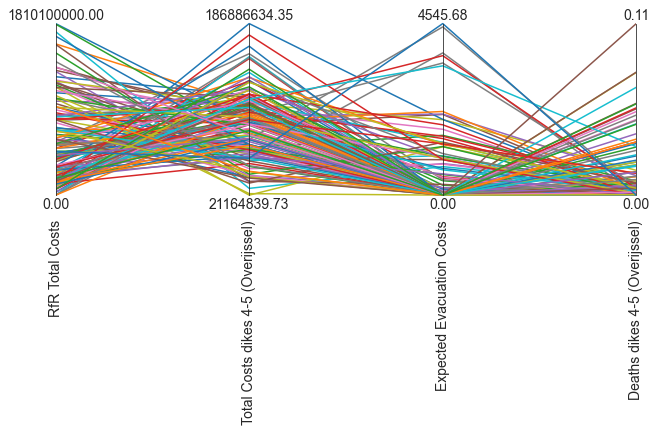

In [301]:
# Plot trade-offs for Overijssel

dataO = selections.loc[:, ['RfR Total Costs', 'Total Costs dikes 4-5 (Overijssel)',
                           'Expected Evacuation Costs', 'Deaths dikes 4-5 (Overijssel)']]

# Set limits of the axes to range from 0 to the maximum values for the number of deaths
limits = parcoords.get_limits(dataO)
limits.loc[0, ['Deaths dikes 4-5 (Overijssel)']] = 0 

# Plot parallel coordinates
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(dataO)

fig = plt.gcf()
fig.set_size_inches(10,15)

plt.show()

For both provinces the parallel coordinate plots are quite similar. The RfR costs and Total costs seem to have a slight negative correlation. It makes sense that in optimal solutions, there is either a focus on dike increases or on RfR projects, and not both if unnecessary to ensure safety. Moreover, high evacution costs seem to coincide with relatively low total costs and deaths and vice versa. This is likely due to the fact that, when people are evacuated on a large scale, deaths and damage costs can be avoided. However, there are also solutions with relatively low scores for all outcomes, which is a positive result. 

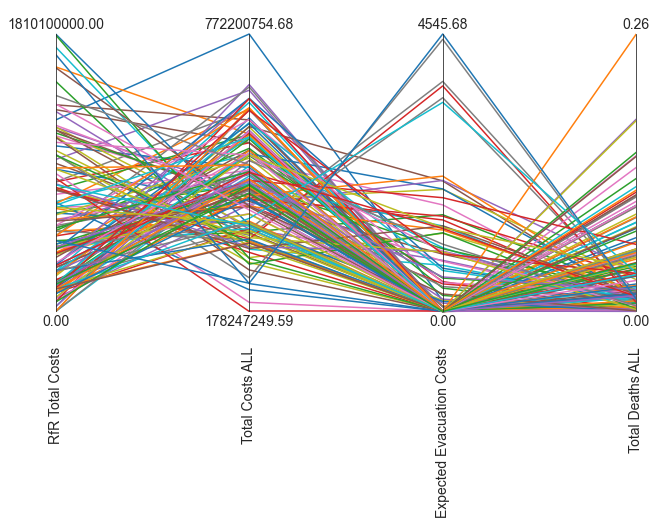

In [302]:
# Plot trade-offs for Rijkswaterstaat

dataR = selections.loc[:, ['RfR Total Costs', 'Total Costs ALL', 
                           'Expected Evacuation Costs', 'Total Deaths ALL']]

# Set limits of the axes to range from 0 to the maximum values for the number of deaths
limits = parcoords.get_limits(dataR)
limits.loc[0, ['Total Deaths ALL']] = 0 

# Plot parallel coordinates
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(dataR)

fig = plt.gcf()
fig.set_size_inches(10,15)

plt.show()

For the outcomes of interest for RWS, also no clear trade-offs are visible. It seems that high evacuation costs have low deaths and medium total costs (dike investment and damages). Again, solutions with relatively low costs and deaths seem to be possible.

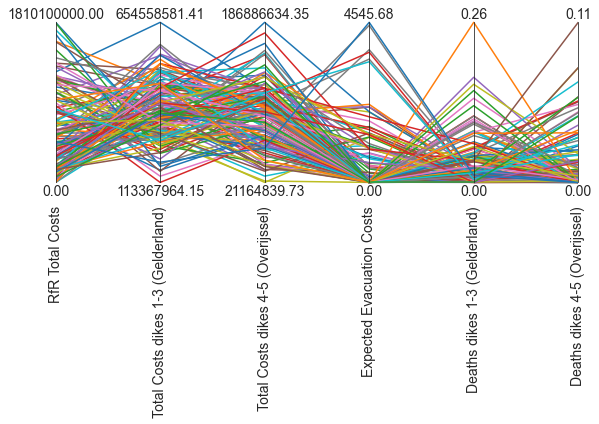

In [303]:
# Plot parallel axes of actors combined

data_all = selections.loc[:, ['RfR Total Costs','Total Costs dikes 1-3 (Gelderland)', 'Total Costs dikes 4-5 (Overijssel)',
                              'Expected Evacuation Costs','Deaths dikes 1-3 (Gelderland)','Deaths dikes 4-5 (Overijssel)']]

limits = parcoords.get_limits(data_all)

limits.loc[0, ['Deaths dikes 1-3 (Gelderland)','Deaths dikes 4-5 (Overijssel)']] = 0  

paraxes = parcoords.ParallelAxes(limits)

paraxes.plot(data_all)

fig = plt.gcf()
fig.set_size_inches(9,16)

plt.show()

In addition to the previous plots, some insights result from plotting trade-offs for the actors combined. 

It seems like there is often a trade-off between number of deaths between the provinces. In the case of a high river volume, the water needs to go somewhere. If a dike breaks in Gelderland, which is located upstream, the water levels in Overijssel are decreased. Similarly, if dikes are heightened in Gelderland, all of the water flows to Overijssel, potentially causing floods there. Still, there are many solutions for which the number of deaths in both provinces is low. In general, the number of deaths in Gelderland is higher.

The total costs also don't show a clear pattern. The axes are different, so the total costs in Gelderland are much higher than those for Overijssel. 

Lastly, there seem to be plenty of solutions with low evacuation costs and deaths. Although these never have low total and RfR costs, it is promising to see that safe options seem to be possible.

## Robustness - Domain Criterion and Minimax Regret

In this section, the solutions from the optimization are re-evaluated under deep uncertainty to measure the robustness. Two robustness metrics have been selected: the domain criterion and minimax regret.

We assume the most important outcomes for the actors to be the following:
- Gelderland: Low number of deaths in locations 1-3
- Overijssel: Low number of deaths in locations 4-5
- Rijkswaterstaat: Low overall costs (damages, dike investments, evacuation, RfR)

Since the RfR costs are consistent within a certain policy, this outcome is not considered in measuring robustness.

In [305]:
# Create policy objects from selected solutions after dropping the outcomes and new columns
policies = selections.drop(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs', 'Total Costs dikes 1-3 (Gelderland)',
       'Deaths dikes 1-3 (Gelderland)', 
       'Total Costs dikes 4-5 (Overijssel)', 'Deaths dikes 4-5 (Overijssel)',
       'Total Costs all dikes (RWS)'], axis=1)

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [17]:
# # Re-evaluate candidate solutions under uncertainty
# n_scenarios = 100

# with MultiprocessingEvaluator(model) as evaluator:
#     results_reeval = evaluator.perform_experiments(n_scenarios,policies_to_evaluate, uncertainty_sampling=LHS)

# experiments_reeval, outcomes_reeval = results_reeval

# save_results((experiments_reeval, outcomes_reeval), './results_reeval_final.tar.gz')

In [27]:
experiments_reeval, outcomes_reeval = load_results('results_reeval_final.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Gebruiker\Documents\GitHub\EPA1361_assignments\v8 final assignment\results_reeval_final.tar.gz


Create extra columns in the outcomes DataFrame to aggregate outcomes, for a better analysis.

In [28]:
outcomes_reeval_df = pd.DataFrame(outcomes_reeval)

# Calculate total costs and number of expected deaths for the three Gelderland dikes
listH = outcomes_reeval_df[['A.1 Total Costs', 'A.2 Total Costs', 'A.3 Total Costs', 'A.4 Total Costs', 
                            'A.5 Total Costs', 'Expected Evacuation Costs']]
outcomes_reeval_df['Total Costs + evacuation'] = listH.sum(1)

listI = outcomes_reeval_df[['A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 
                            'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 
                            'A.5_Expected Number of Deaths']]
outcomes_reeval_df['Total Deaths ALL'] = listI.sum(1)   


## Domain Criterion

Extra keys in the outcomes dictionary are created for the outcomes of interest of the three actors. These are used to measure the domain criterion. 

In [29]:
# Perform the same sums in the dictionary for the domain criterion robustness function
outcomes_reeval['Total Costs All + evacuation'] = sum([outcomes_reeval[column] for column in [
                                                                                 'A.1 Total Costs',
                                                                                 'A.2 Total Costs',
                                                                                 'A.3 Total Costs',
                                                                                 'A.4 Total Costs',
                                                                                 'A.5 Total Costs', 
                                                                                 'Expected Evacuation Costs'
                                                                                 ]])

outcomes_reeval['Total Deaths Gelderland'] = sum([outcomes_reeval[column] for column in ['A.1_Expected Number of Deaths',
                                                                                         'A.2_Expected Number of Deaths', 
                                                                                         'A.3_Expected Number of Deaths']])

outcomes_reeval['Total Deaths Overijssel'] = sum([outcomes_reeval[column] for column in ['A.4_Expected Number of Deaths', 
                                                                                         'A.5_Expected Number of Deaths']])

# Create new dictionary and dataframe with only outcomes of interest for domain criterion
keys_robustness = ['Total Deaths Gelderland', 'Total Deaths Overijssel', 'Total Costs All + evacuation']
outcomes_robustness = {x:outcomes_reeval[x] for x in keys_robustness}
outcomes_robustness_df = pd.DataFrame(outcomes_robustness)


In [30]:
# Define robustness functions

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'
LARGER = 'LARGER'

deaths = functools.partial(robustness, SMALLER, 0.005) # Half of 0.01 (nfe) for both Provinces 
costs = functools.partial(robustness, SMALLER, 6e+8) # Sum of investment + annual damages + evacuation, approx RWS budget


In [31]:
# Calculate domain criterion as robustness metric for:
# Total costs + evacuation costs for all provinces (for RWS) and total number of deaths per province

domain_df = pd.DataFrame()

list_costs = []
list_deathsG = []
list_deathsO = []

list_outcomes = [list_deathsG, list_deathsO, list_costs]
list_robustness_functions = [deaths, deaths, costs]

for policy in np.unique(experiments_reeval['policy']):
    logical = experiments_reeval['policy'] == policy
    for values, lst, rob_func in zip(outcomes_robustness.values(), list_outcomes, list_robustness_functions):
        data = values[logical]
        lst.append(rob_func(data))
        
for outcome, rob_scores in zip(outcomes_robustness.keys(), list_outcomes):
    domain_df[outcome] = rob_scores

domain_df

Total Deaths Gelderland  Total Deaths Overijssel  \
0                       0.69                     0.99   
1                       1.00                     0.93   
2                       0.73                     0.97   
3                       0.64                     0.94   
4                       0.74                     0.80   
5                       0.83                     0.95   
6                       0.74                     0.95   
7                       0.70                     0.93   
8                       0.81                     0.86   
9                       0.97                     0.63   
10                      0.38                     0.52   
11                      0.86                     0.90   
12                      0.61                     0.87   
13                      0.17                     0.83   
14                      0.82                     0.93   
15                      0.11                     0.97   
16                      0.19                     0.87   
17                      0.05                     0.75   
18                      0.10                     0.34   
19                      0.10                     0.44   
20                      0.70                     0.10   
21                      0.01                     0.55   
22                      0.19                     0.41   
23                      0.18                     0.68   
24                      0.39                     0.50   
25                      0.31                     0.49   
26                      0.54                     0.37   
27                      0.18                     0.98   
28                      0.16                     0.53   
29                      0.18                     0.84   
30                      0.11                     0.99   
31                      0.03                     0.52   
32                      0.05                     0.25   
33                      0.01                     0.80   
34                      0.00                     0.50   
35                      0.34                     0.28   
36                      0.33                     0.17   
37                      0.32                     0.52   
38                      0.38                     0.78   
39                      0.51                     0.47   
40                      0.38                     0.12   
41                      0.41                     0.84   
42                      0.38                     0.68   
43                      0.02                     0.34   
44                      0.31                     0.34   
45                      0.09                     0.55   
46                      0.07                     0.63   
47                      0.25                     0.54   
48                      0.03                     0.45   
49                      0.15                     0.59   
50                      0.00                     0.38   
51                      0.31                     0.51   
52                      0.78                     0.25   
53                      0.00                     0.61   
54                      0.06                     0.44   
55                      0.53                     0.17   
56                      0.00                     0.49   
57                      0.03                     0.70   
58                      0.01                     0.51   
59                      0.37                     0.19   
60                      0.02                     0.39   
61                      0.83                     0.36   
62                      0.17                     0.55   
63                      0.14                     0.36   
64                      0.39                     0.38   
65                      0.26                     0.40   
66                      0.01                     0.78   
67                      0.12                     0.45   
68                      0.00                     0.43   
69             

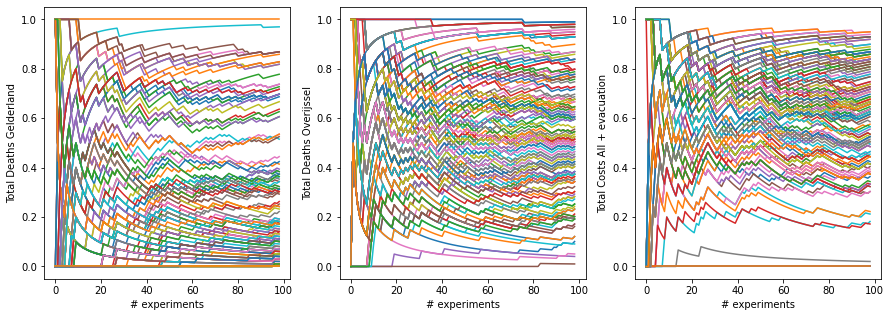

In [32]:
# Plot robustness for domain criterion per number of experiments to assess convergence

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5),
                        sharex=True)

axes = [axes[0],axes[1],axes[2]]

robustness_funcs = {'Total Deaths Gelderland': deaths,
                    'Total Deaths Overijssel': deaths,
                    'Total Costs All + evacuation': costs
                    }

robustness_scores = []

for ax, (outcome, value) in zip(axes, outcomes_robustness.items()):
    for policy in np.unique(experiments_reeval['policy']):
        logical = experiments_reeval['policy'] == policy
        data = value[logical]
        
        robustness = []
        
       # data.shape should be (100,), given n_scenarios=100
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        
        ax.plot(robustness, label=policy)
    ax.set_xlabel('# experiments')
    ax.set_ylabel(outcome)
    


From the figures it is visible that robustness scores converge from around 60 experiments. Therefore, 100 is a sufficient number of experiments to measure the robustness of the outcomes. Furthermore, it is observed that the robustness scores vary a lot.

## Policy selection

In the next section, selections are made from the list of solutions. These are based on the assumed preferences for the different actors, and for two different robustness metrics. Incorporating rival problem framings can help the province Gelderland in the decision-making process, as other parties might be more likely accept Gelderland's proposals when their own interests are also considered. Moreover, the two robustness metrics allow for different political choices, for example on the level of risk aversion.

Solutions are selected if they fall within in the best percentiles of the robustness scores for all three actors. For the domain criterion, the 80th percentile is used (the best possible score is 1). Since using the worst-case scenario for the robustness score is less stable, the  30th percentile is used (the best possible score is 0). These percentiles are selected by experimenting based on the number of remaining solutions.

### Domain Criterion

In [35]:
# Calculate 80th percentiles
domain_q80_G = domain_df['Total Deaths Gelderland'].quantile(0.8) 
domain_q80_O = domain_df['Total Deaths Overijssel'].quantile(0.8) 
domain_q80_RWS = domain_df['Total Costs All + evacuation'].quantile(0.8) 

G_death_domain_rank = domain_df['Total Deaths Gelderland'] >= domain_q80_G
O_death_domain_rank = domain_df['Total Deaths Overijssel'] >= domain_q80_O
RWS_cost_domain_rank = domain_df['Total Costs All + evacuation'] >= domain_q80_RWS

print("80th percentile domain criterion robustness scores scores for Gelderland, Overijssel, RWS:")
print(domain_q80_G)
print(domain_q80_O)
print(domain_q80_RWS)

domain_rank = domain_df[G_death_domain_rank & O_death_domain_rank & RWS_cost_domain_rank]
domain_policies = domain_rank.index.values.tolist()

# Copy to maintain original
domain_policies2 = domain_policies 

domain_rank


80th percentile domain criterion robustness scores scores for Gelderland, Overijssel, RWS:
0.5360000000000001
0.786
0.82


Total Deaths Gelderland  Total Deaths Overijssel  \
1                      1.00                     0.93   
2                      0.73                     0.97   
4                      0.74                     0.80   
5                      0.83                     0.95   
6                      0.74                     0.95   
70                     0.70                     0.93   

    Total Costs All + evacuation  
1                           0.92  
2                           0.87  
4                           0.90  
5                           0.83  
6                           0.95  
70                          0.93

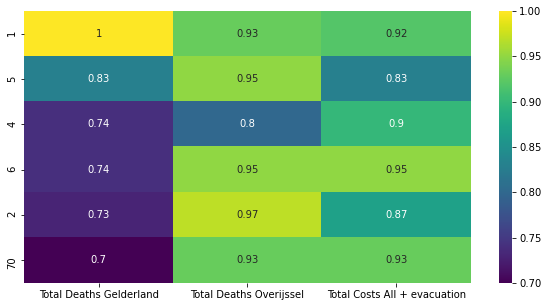

In [36]:
# Plot heat map of the selected solutions based on the domain criterion robustness score
plt.figure(figsize=(10,5))

sns.heatmap(domain_rank.sort_values(['Total Deaths Gelderland'], ascending=False), cmap='viridis', annot=True)

plt.show()

In [37]:
print('The indices of the policies resulting from this selection based on domain criterion are:')
domain_rank.index.values.tolist()

The indices of the policies resulting from this selection based on domain criterion are:


[1, 2, 4, 5, 6, 70]

Out of the 143 solutions, 6 policies have robustnes scores in the 80th percentile for all three problem framings. All scores are above 70%, which is quite high. Policies 1 and 2 seem particularly promising in terms of the robustness scores, but all options are quite robust. Therefore, the eventual policy selection will more likely depend on the levers used within these policies, which have not been alayzed so far. This will be done in the next section, after calculating minimax regret as the second robustness metric.

### Worst Case using Minimax Regret

In [38]:
# Calculate minimax regret for all outcomes of interest

def calculate_regret(data, best):
    return np.abs(best-data)


overall_regret = {}
max_regret = {}
for outcome in outcomes_robustness.keys():
    policy_column = experiments_reeval['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome: outcomes_reeval[outcome], 
                         'policy':experiments_reeval['policy'],
                         'scenario':experiments_reeval['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting
    data.columns = data.columns.get_level_values(1)
    
    # take the difference of the maximum across 
    # the row and the actual values in the row
    
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome] = outcome_regret
    max_regret[outcome] = outcome_regret.max()
    
max_regret = pd.DataFrame(max_regret)    
worst_case_df = max_regret/max_regret.max()

C:\Users\Gebruiker\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [43]:
# Calculate 30th percentiles

worst_case_q30_G = worst_case_df['Total Deaths Gelderland'].quantile(0.3) 
worst_case_q30_O = worst_case_df['Total Deaths Overijssel'].quantile(0.3) 
worst_case_q30_RWS = worst_case_df['Total Costs All + evacuation'].quantile(0.3) 

#  60, 67, 75, 98, 110, 137, 141 with 0.6,     60, 87, 98, 137, 110, 119, 141
# Difference: 75, 67 vs 119, 87

G_death_minimax_rank = worst_case_df['Total Deaths Gelderland'] <= worst_case_q30_G
O_death_minimax_rank = worst_case_df['Total Deaths Overijssel'] <= worst_case_q30_O
RWS_cost_minimax_rank = worst_case_df['Total Costs All + evacuation'] <= worst_case_q30_RWS

print("80th percentile minimax regret robustness scores scores for Gelderland, Overijssel, RWS:")
print(worst_case_q30_G)
print(worst_case_q30_O)
print(worst_case_q30_RWS)


# Selection with high robustness (low scores)

worst_case_rank = worst_case_df[G_death_minimax_rank & O_death_minimax_rank & RWS_cost_minimax_rank]
worst_case_policies = worst_case_rank.index.values.tolist()

all_policies = domain_policies2.extend(worst_case_policies)

worst_case_rank

80th percentile minimax regret robustness scores scores for Gelderland, Overijssel, RWS:
0.7189064286377438
0.7284505607663646
0.7697858095023793


Total Deaths Gelderland  Total Deaths Overijssel  \
policy                                                     
34                     0.374205                 0.711268   
56                     0.377522                 0.711268   
67                     0.483512                 0.640222   
75                     0.568437                 0.618401   
98                     0.381263                 0.484112   
107                    0.475735                 0.699072   
137                    0.400060                 0.589741   
141                    0.444376                 0.436194   

        Total Costs All + evacuation  
policy                                
34                          0.654002  
56                          0.668958  
67                          0.692151  
75                          0.621013  
98                          0.677983  
107                         0.682053  
137                         0.679763  
141                         0.713868

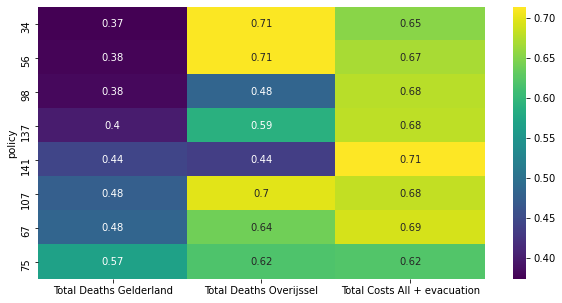

In [40]:
# Plot minimax regret of policy election
plt.figure(figsize=(10,5))
sns.heatmap(worst_case_rank.sort_values(['Total Deaths Gelderland']), cmap='viridis', annot=True)

plt.show()

In [41]:
print('The indices of the policies resulting from this selection based on minimax regret are:')
worst_case_rank.index.values.tolist()

The indices of the policies resulting from this selection based on minimax regret are:


[34, 56, 67, 75, 98, 107, 137, 141]

Out of the 143 solutions, 8 policies have robustnes scores in the 30th percentile for all three problem framings. The scores range between 0,71 and 0,37. These scores are not particularly good, but since the minimax regret focuses on a single worst-case scenario and not on the entire set, this is not surprising. Since these are the options with the highest scores, they will be used for further analysis. As mentioned before, this will be based on the policy levers of the selection solutions, since different levers can have different political and societal implications.

None of the solutions overlap between the two robustness metrics. To avoid biases, the two sets of solutions have therefore been analyzed separetely to produce a recommendation. 

## Inspect levers of policy selection

Some aggregations of the different policy levers are produced to plot trade-offs of the solutions resulting from the robustness metrics. These, in addition to the solutions tables are used to select the final policy recommendations.

### Policies from domain criterion

In [42]:
# Aggregate levers for the two provinces: RfR total increases, RfR in time step 0, dike increases

listJ = solutions_df[['0_RfR 0','1_RfR 0', '2_RfR 0']]
solutions_df['Time step 0 - RfR 1-3 (Gelderland)'] = listJ.sum(1)

listK = solutions_df[['3_RfR 0','4_RfR 0']]
solutions_df['Time step 0 - RfR 4-5 (Overijssel)'] = listK.sum(1)

listL = solutions_df[[
        '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
        '2_RfR 0', '2_RfR 1', '2_RfR 2'
        ]]
solutions_df['Total RfR 1-3 (Gelderland)'] = listL.sum(1)
        
listM = solutions_df[[
        '3_RfR 0', '3_RfR 1', '3_RfR 2',
        '4_RfR 0', '4_RfR 1', '4_RfR 2'
        ]]
solutions_df['Total RfR 4-5 (Overijssel)'] = listM.sum(1)

listN = solutions_df[[
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
        ]]
solutions_df['Total dike increase A1-3 (Gelderland)'] = listN.sum(1)
                      
listO = solutions_df[[
        'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
        'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'
        ]]
solutions_df['Total dike increase A4-5 (Overijssel)'] = listO.sum(1)
                
     

In [46]:
domain_df = solutions_df.iloc[domain_rank.index.values.tolist()]
domain_df.iloc[:, -9:]

Total Costs all dikes (RWS)  Total Costs ALL  Total Deaths ALL  \
1                  2.154083e+09     5.581829e+08          0.000130   
2                  1.054263e+09     5.273630e+08          0.000560   
4                  1.636728e+09     4.354279e+08          0.000403   
5                  1.856367e+09     5.397674e+08          0.000130   
6                  1.043807e+09     4.435072e+08          0.000000   
70                 2.173704e+09     3.636042e+08          0.000503   

    Time step 0 - RfR 1-3 (Gelderland)  Time step 0 - RfR 4-5 (Overijssel)  \
1                                    2                                   1   
2                                    1                                   1   
4                                    1                                   1   
5                                    3                                   1   
6                                    2                                   1   
70                                   3                                   1   

    Total RfR 1-3 (Gelderland)  Total RfR 4-5 (Overijssel)  \
1                            6                           5   
2                            4                           2   
4                            5                           4   
5                            7                           4   
6                            6                           1   
70                           6                           5   

    Total dike increase A1-3 (Gelderland)  \
1                                      37   
2                                      32   
4                                      31   
5                                      31   
6                                      24   
70                                     23   

    Total dike increase A4-5 (Overijssel)  
1                                      20  
2                                      26  
4                                       4  
5                                      26  
6                                      25  
70                                      7

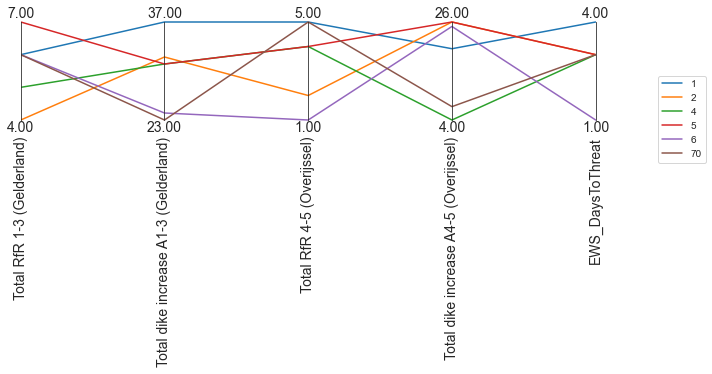

In [347]:
# Plot parallel axes of policy levers to observe trade-offs.

data_domain = domain_df.loc[:, [
       'Total RfR 1-3 (Gelderland)', 'Total dike increase A1-3 (Gelderland)',
       'Total RfR 4-5 (Overijssel)', 'Total dike increase A4-5 (Overijssel)', 
       'EWS_DaysToThreat'
        ]]

limits = parcoords.get_limits(data_domain)

paraxes = parcoords.ParallelAxes(limits)

paraxes.plot(data_domain)

fig = plt.gcf()
fig.set_size_inches(9,16)
plt.legend(domain_df.index, bbox_to_anchor=(1.8, 0.5))
plt.show()

From this parallel coordinate plot it becomes visible that for both provinces there is often a trade-off between RfR and dike increases. Considering the solutions are optimal, it makes sense that they are not unnecessarily implemented at high levels at the same time. No solution seems to score low on all plotted outcomes, so political preference will be the main factor here. 

Based on the levers and trade-offs, we recommend policies number **2, 4, and 6** to be presented to Gelderland as options, if they have a preference for a solution that performs well in many possible futures. 

Policies 2 and 4 only entail 1 Room for the River project in the first time step, which spans over 25 years. In this case, it will be possible to warn farmers in the selected RfR areas well in advance and to negotiate with them about a suitable arrangement in terms of selling their agricultural lands. In total there will be 4 RfR projects implemented and 32 decimeters of dike increases are necessary at various locations. 

Policy number entails two RfR projects in the first 25 years. However, dike increases will only comprise of a total of 24 decimeters. Moreover, for almost all three options it will be necessary that Overijssel implements similar policies, except for policy 6 in which only 1 RfR project is necessary in that province.

The aggregated costs, which we assume to be paid by RWS, are quite high, namely between 1 and 1.6 billion euros. Although this is well above the estimated budget in the reference scenario, these are on the lower end of the solutions we found. Since all actors, including RWS were considered when making this selection, we think it will be possible to convince RWS that this budget is necessary. Moreover, the domain criterion scores were between 0.87 and 0.95 for the total costs, meaning that in around 90% of the scenarios the costs were below 700 million, which we set as their budget.

### Policies from minimax selection

In [47]:
minimax_df = solutions_df.iloc[worst_case_rank.index.values.tolist()]
minimax_df.iloc[:, -9:]

Total Costs all dikes (RWS)  Total Costs ALL  Total Deaths ALL  \
34                  7.652386e+08     4.628386e+08          0.183561   
56                  1.089570e+09     4.081700e+08          0.148755   
67                  1.151306e+09     6.587058e+08          0.089711   
75                  7.279932e+08     4.411932e+08          0.111420   
98                  8.120699e+08     3.867699e+08          0.182222   
107                 1.017910e+09     4.714095e+08          0.101315   
137                 1.902106e+09     4.924057e+08          0.109356   
141                 1.427591e+09     4.917915e+08          0.115801   

     Time step 0 - RfR 1-3 (Gelderland)  Time step 0 - RfR 4-5 (Overijssel)  \
34                                    0                                   0   
56                                    1                                   1   
67                                    0                                   0   
75                                    0                                   1   
98                                    0                                   0   
107                                   1                                   0   
137                                   1                                   2   
141                                   1                                   1   

     Total RfR 1-3 (Gelderland)  Total RfR 4-5 (Overijssel)  \
34                            2                           0   
56                            2                           2   
67                            2                           2   
75                            1                           1   
98                            2                           1   
107                           2                           2   
137                           3                           4   
141                           2                           3   

     Total dike increase A1-3 (Gelderland)  \
34                                      21   
56                                      17   
67                                      42   
75                                      17   
98                                      14   
107                                     27   
137                                     29   
141                                     29   

     Total dike increase A4-5 (Overijssel)  
34                                      15  
56                                      11  
67                                       7  
75                                       9  
98                                      15  
107                                     10  
137                                      5  
141                                      2

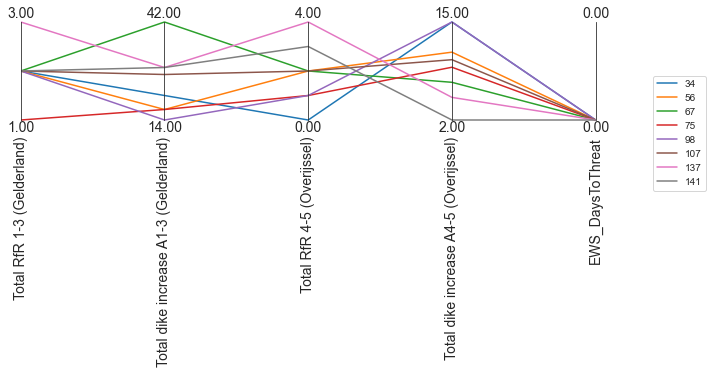

In [348]:
# Plot parallel axes of policy levers to observe trade-offs.

data_minimax = minimax_df.loc[:, [
       'Total RfR 1-3 (Gelderland)', 'Total dike increase A1-3 (Gelderland)',
       'Total RfR 4-5 (Overijssel)', 'Total dike increase A4-5 (Overijssel)', 
       'EWS_DaysToThreat'
        ]]

limits = parcoords.get_limits(data_minimax)

paraxes = parcoords.ParallelAxes(limits)

paraxes.plot(data_minimax)

fig = plt.gcf()
fig.set_size_inches(9,16)
plt.legend(minimax_df.index, bbox_to_anchor=(1.8, 0.5))
plt.show()

In this parallel coordinate plot less clear trade-offs can be observed, except for the trade-off between RfR and dike increases in Overijssel. Another interesting find is that all solutions do not entail an early warning system measure. Since this robustness metric minimizes negative outcomes in the worst-case scenario, it would make sense that the RfR and dike increase implementations are sufficiently safe such that floods are avoided completely and no evacuations are necessary. However, the ranges for the dike increases and RfR measures are almost all lower than those of the domain criterion robustness metric. As we could see that the 30th percentile for this robustness metric had quite high values, this might not be the most suitable metric. Nevertheless, it is included in case risk aversion is considered one of the more important aspects of the policy selection.

Based on the levers and trade-offs, we recommend policies number **34, 67 and 107** to be presented to Gelderland as possible options, if a high level of risk aversion is considered the most important. 

For Gelderland, policy number 34 has no RfR projects in the first 25 years, only 2 RfR project in total, and relatively  required dike heightenings that are somewhere in the middle of the options, namely a total increase of 21 decimeters. Similar policies are required in Overijssel for this policy. Policy number 107 does include 1 RfR project in the first time step and 27 decimeters of dike heightenings. Similarly, policy number 67 has similar RfR projects and is even slightly more safe, although the dike increases then entail 42 decimeters.

The aggregated costs in the reference scenario are between 760 million and 1.2 billion euros. The minimax regret robustness score was 0.68 or 0.69 for all three solutions. Since the optimal score would have been 0, this is a low score. Moreover, the scores for domain criterion for all three solutions are also very low for all three objectives. Therefore, it is strongly recommend to only consider the previously proposed policies. 


## Conclusion: Recommendation

From the MORDM optimization and a subsequent re-evaluation of the solutions under deep uncertainty, a selection of policy has resulted. The Gelderland province is recommended to consider policies number **2, 4, and 6**. The detailed levers of these policies can be found below.  

In [361]:
solutions_df.iloc[[2, 4, 6], :16]

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
2        1        1        1        0        0        0        0        1   
4        0        0        1        0        1        1        1        1   
6        1        0        1        0        1        0        1        1   

   2_RfR 2  3_RfR 0  3_RfR 1  3_RfR 2  4_RfR 0  4_RfR 1  4_RfR 2  \
2        0        1        0        1        0        0        0   
4        0        1        1        1        0        0        1   
6        1        1        0        0        0        0        0   

   EWS_DaysToThreat  
2                 3  
4                 3  
6                 1

In [50]:
solutions_df.iloc[[2, 4, 6], 16:31]

A.1_DikeIncrease 0  A.1_DikeIncrease 1  A.1_DikeIncrease 2  \
2                   3                   6                   3   
4                   4                   3                   1   
6                   2                   0                   5   

   A.2_DikeIncrease 0  A.2_DikeIncrease 1  A.2_DikeIncrease 2  \
2                   1                   2                   3   
4                   6                   4                   1   
6                   6                   1                   3   

   A.3_DikeIncrease 0  A.3_DikeIncrease 1  A.3_DikeIncrease 2  \
2                   3                   7                   4   
4                   0                   8                   4   
6                   1                   0                   6   

   A.4_DikeIncrease 0  A.4_DikeIncrease 1  A.4_DikeIncrease 2  \
2                   6                   1                  10   
4                   2                   0                   1   
6                   4                   4                   6   

   A.5_DikeIncrease 0  A.5_DikeIncrease 1  A.5_DikeIncrease 2  
2                   5                   0                   4  
4                   0                   0                   1  
6                   6                   0                   5